# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [76]:
%config InlineBackend.figure_format = 'retina'

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

$\text{Функционал, минимизуруемый в kmeans: }$


$$L(C)=\sum_{k=1}^{K} \sum_{i \in C_{k}}\left\|x_{i}-\mu_{k}\right\|^{2} \rightarrow \min _{C}$$
$$\mu_{k}=\frac{1}{\left|C_{k}\right|} \sum_{x_{n} \in C_{k}} x_{n}$$

$E \text{ шаг: определение кластеров для точек}$

$$C_{k}=\left\{x_{n}:\left\|x_{n}-\mu_{k}\right\|^{2} \leq\left\|x_{n}-\mu_{l}\right\|^{2} \quad \forall l \neq k\right\}$$

На этом шаге центроиды фиксированы и кластеры для точек определяются, исходя из их близости к центроидам.

В обоих случаях, когда уже был совершен  $M$ шаг и когда центроиды были выбраны случайно при инициализации, функционал не увеличивается.


$M \text{ шаг: пересчет и обновление центроидов}$
$$\mu_{k}=\frac{1}{\left|C_{k}\right|} \sum_{x_{n} \in C_{k}} x_{n}$$

На этом шаге фиксированы кластеры для всех точек и уже центроиды пересчитываются, исходя из положений (расстояний) точек кластера относительно центра. На этом шаге функционал тоже не может увеличиться.

Так как функционал не может увеличиться ни на $E$ шаге, ни на $М$ шаге, функционал не увеличивается на протяжении работы всего алгоритма.

Так же можно сказать, что функционал ограничен, исходя из того, что на некотором $M$ шаге никакой из центроидов не обновится или они обновятся на малую величину.

Так как каждый объект мы можем отнести к одному из $k$ кластеров, объектов у нас $N$, а функционал не увеличивается и ограничен, то количество итераций не будет превышать $k^N$ -- ситуации, когда в работе алгоритма мы попытаемся отнести каждый возможный объект в каждый возможный кластер.

Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$



***Ваше решение здесь***

$$\ln{L(\mu)} = \sum\limits_{i=1}^N \ln{p(x_i|\mu)} $$

$$\frac{\partial \ln{L(\mu)}}{\partial \mu} = \sum\limits_{i=1}^N \frac{\partial \ln{p(x_i|\mu)}}{\partial \mu} = 0$$

$$\frac{\partial}{\partial \mu} \sum\limits_{i=1}^N \frac{\frac{-1}{2} (x_i-\mu)^T \Sigma^{-1} (x_i - \mu)}{(2\pi)^{n/2} |\Sigma|^{1/2}} = \sum\limits_{i=1}^N \frac{\frac{1}{2} \Sigma^{-1} (x_i - \mu)}{(2\pi)^{n/2} |\Sigma|^{1/2}} = 0$$

$$\mu = \frac{\Sigma^{-1}}{2(2\pi)^{n/2} |\Sigma|^{1/2}} \frac{1}{N} \sum\limits_{i=1}^N x_i$$

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

Используя соотношения на минимум и максимум для чисел имеем:

$$d_{\min}(U \cup V, S) = \min(d_{\min}(U, S), d_{\min}(V, S)) = \min(A, B) = \frac{1}{2}(A + B - |A-B|)$$ $$d_{\max}(U \cup V, S) = \max(d_{\max}(U, S), d_{\max}(V, S)) = \max(A, B) = \frac{1}{2}(A + B + |A-B|)$$

После подстановки обратно вместо $A \rightarrow d_{\min}(U, S)$ (для максимума $d_{\max}(U, S)$), вместо $B \rightarrow d_{\min}(V, S)$ (для максимума $d_{\max}(V, S)$) получаем искомые соотношения.

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [310]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import euclidean_distances as EuclDist
from sklearn.metrics.pairwise import cosine_distances as CosDist
from itertools import combinations
from copy import deepcopy
from scipy.cluster.hierarchy import dendrogram

class Clustering(BaseEstimator, ClusterMixin):
    
    def __init__(self, k = 2, metric='euclidean', linkage='single', **kwargs):
        self.Z = []
        self.k = k
        self.linkage = linkage
        self.metric = metric
        
        if linkage == 'single':
            self.cluster_distance = self.single_linkage
        elif linkage == 'complete':
            self.cluster_distance = self.complete_linkage
        elif linkage == 'average':
            self.cluster_distance = self.average_linkage
        else:
            raise ValueError('Not supported type of linkage')
        return

    def single_linkage(self, c_1, c_2):
        return np.min(self.Distances[c_1].T[c_2])

    def complete_linkage(self, c_1, c_2):
        return np.max(self.Distances[c_1].T[c_2])

    def average_linkage(self, c_1, c_2):
        return np.sum(self.Distances[c_1].T[c_2])/(len(c_1) * len(c_2))

    def fit(self, x, y=None):
        self.x_len = len(x)
        
        # equal to dist = self.dist(x)
        if self.metric == 'euclidean':
            self.Distances = EuclDist(x)
        elif self.metric == 'cosine':
            self.Distances = CosDist(x)
        else:
            raise ValueError('Not supported metric')
        
        self.clusters = [[x] for x in range(self.x_len)]
        self.clusters_copy = deepcopy(self.clusters)
        
        while len(self.clusters) > self.k:
            c_1, c_2 = self.clusters[0], self.clusters[1]
            distance = self.cluster_distance(c_1, c_2)

            for tmp_c_1, tmp_c_2 in combinations(self.clusters, 2):
                tmp_distance = self.cluster_distance(tmp_c_1, tmp_c_2)
                if tmp_distance < distance:
                    c_1, c_2, distance = tmp_c_1, tmp_c_2, tmp_distance

            self.Z.append([self.clusters_copy.index(c_1), self.clusters_copy.index(c_2),
                           distance, len(c_1)+len(c_2)])
            self.clusters.remove(c_1)
            self.clusters.remove(c_2)
            self.clusters.append(c_1 + c_2)
            self.clusters_copy.append(c_1 + c_2)            
        return self

    def predict(self, x):
        labels = np.ones(self.x_len, dtype=int)
        for cl_num, x_ind in enumerate(self.clusters):
            labels[x_ind] = cl_num
        return labels

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

    def plot_dendrogram(self):
        plt.figure(figsize=(15,9))
        dendrogram(self.Z)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

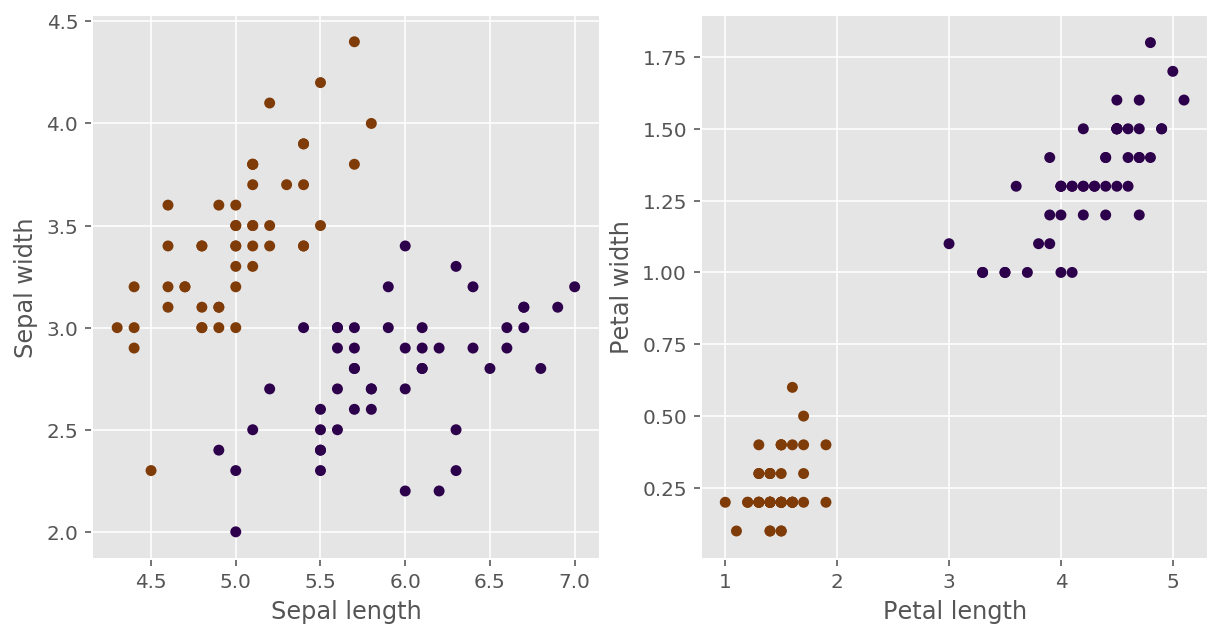

In [311]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [312]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0023660659790039062


In [313]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
custom_aggl = Clustering(metric='euclidean', linkage='average')
aggl_t0 = time.time()
aggl_pred = custom_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 1.879676342010498


In [314]:
custom_aggl.Z

[[7, 39, 0.09999999999995453, 2],
 [0, 17, 0.09999999999999006, 2],
 [10, 48, 0.09999999999999006, 2],
 [9, 34, 0.10000000000002558, 2],
 [27, 28, 0.1414213562372703, 2],
 [4, 37, 0.14142135623729543, 2],
 [63, 91, 0.14142135623729543, 2],
 [80, 81, 0.14142135623729543, 2],
 [82, 92, 0.14142135623729543, 2],
 [95, 96, 0.14142135623729543, 2],
 [1, 12, 0.14142135623732055, 2],
 [2, 47, 0.14142135623732055, 2],
 [8, 38, 0.14142135623732055, 2],
 [19, 21, 0.14142135623732055, 2],
 [29, 30, 0.14142135623734567, 2],
 [57, 93, 0.14142135623734567, 2],
 [65, 75, 0.14142135623739593, 2],
 [40, 101, 0.15731321849708296, 3],
 [49, 100, 0.15731321849709323, 3],
 [45, 110, 0.17071067811867177, 3],
 [88, 109, 0.17320508075691152, 3],
 [94, 99, 0.17320508075693203, 2],
 [25, 103, 0.18660254037849297, 3],
 [3, 111, 0.1931851652578215, 3],
 [46, 113, 0.1931851652578215, 3],
 [104, 117, 0.19897133418246984, 5],
 [23, 26, 0.1999999999999801, 2],
 [53, 89, 0.20000000000001564, 2],
 [66, 84, 0.20000000000

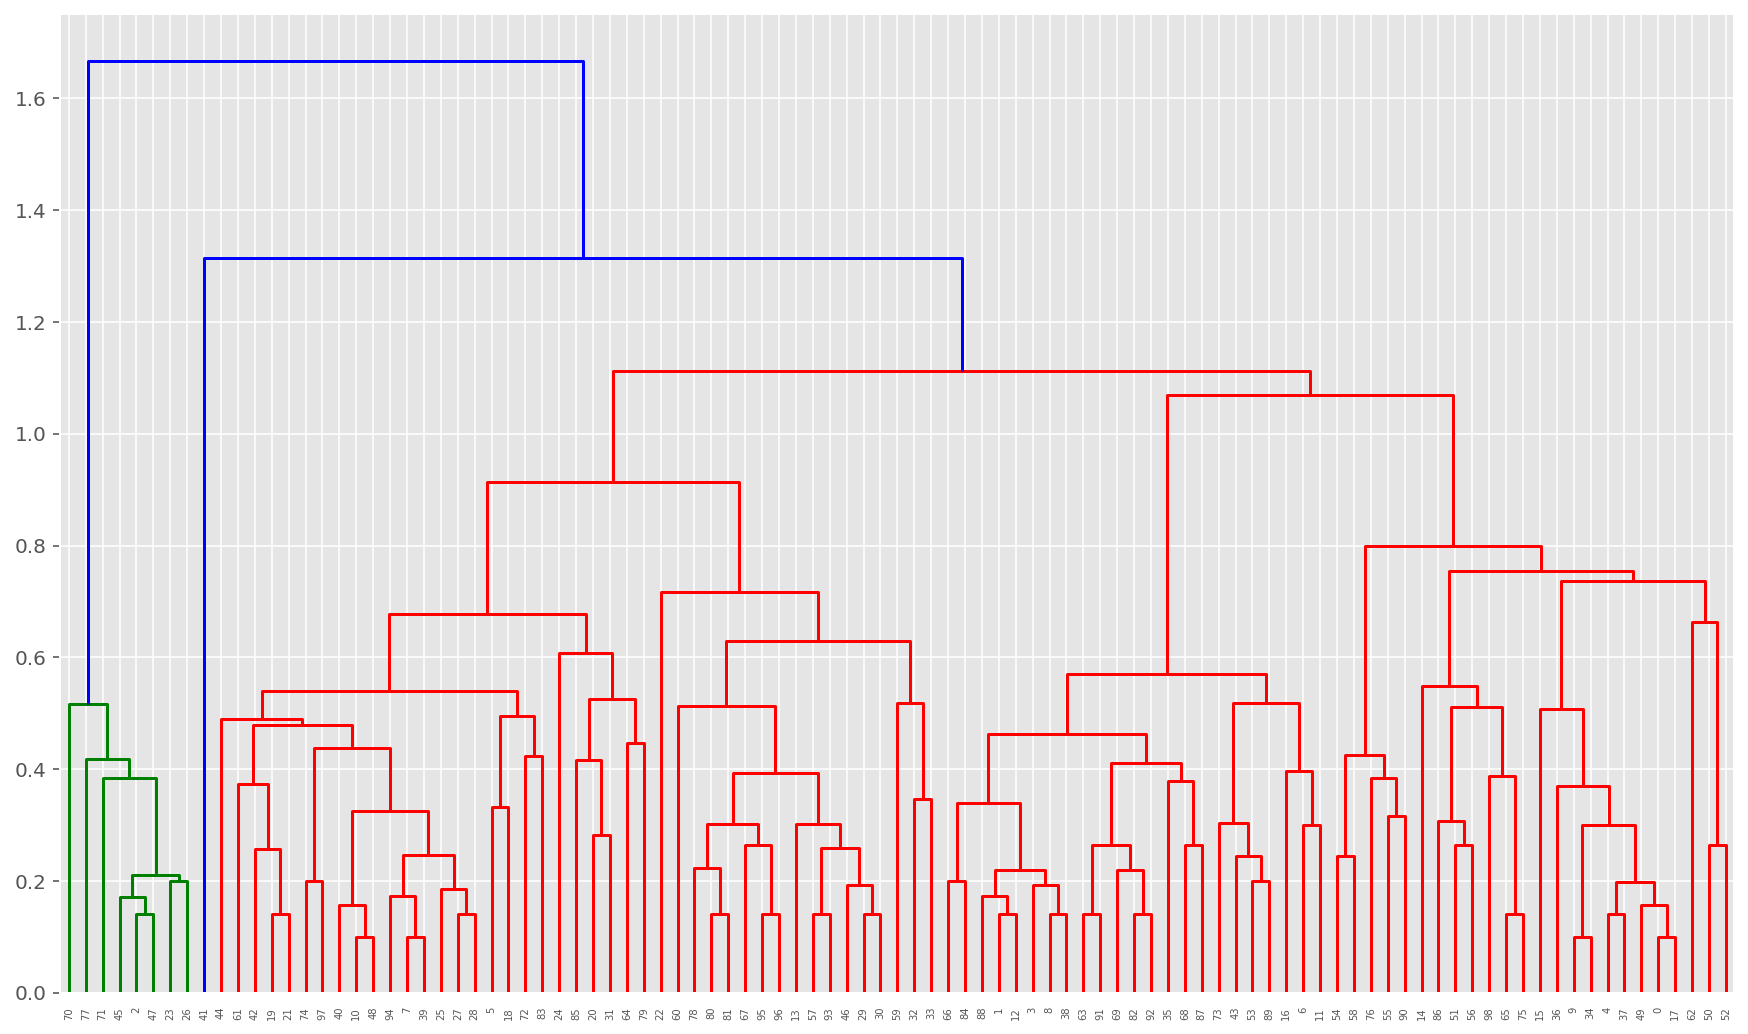

In [315]:
custom_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [237]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [238]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [146]:
# Место для Вашего кластерного анализа
import tqdm
import tqdmfrom itertools import chain
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

comparing_data = []

my_aggl = Clustering(n_clusters=2, metric='cosine', linkage ='average')

groups_titles = [] # Group`s titles 
groups_targets = [] # Group`s targets 
general_set_targets = [] # General set targets
general_set_predicts=[] # General set predicts
for i in tqdm.notebook.tqdm(traingroups_titledata):
    groups_titles.clear()
    groups_targets.clear()
    for pair_id, title, target in traingroups_titledata[i]:
        groups_titles.append(title)
        groups_targets.append(target)
        general_set_targets.append(target)
    x_train = TfidfVectorizer(ngram_range=(1,3)).fit_transform(groups_titles).toarray()

    y_pred = my_aggl.fit_predict(x_train)
    general_set_predicts.append(y_pred)
    comparing_data.append([j, f1_score(groups_targets, y_pred)])

comparing_df = pd.DataFrame(data = comparing_data, columns=['Group_id', 'F_Score'])
general_set_predicts = list(chain(*general_set_predicts))



In [153]:
comparing_df[comparing_df.F_Score > 0.9]

,Group_id,F_Score
21,22,0.931677
25,26,0.960526
32,33,0.966667
48,49,0.973822
49,50,0.970414
59,60,0.933333
76,77,0.969072
86,87,0.936508
99,100,0.965986
120,121,0.962963


In [148]:
print(f1_score(general_set_targets, general_set_predicts))

0.4708257233490339


Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***